In [1]:
import json

# === CONFIGURAZIONE ===
input_file = '../json_valeria/2.json'
output_file = 'polygon.json'

# === FUNZIONE DI CONVERSIONE ===
def estrai_poligono_da_json(percorso_file):
    with open(percorso_file, 'r') as f:
        data = json.load(f)
    
    lines = data.get("lines", [])
    if not lines:
        raise ValueError("Nessuna linea trovata nel file JSON.")

    # Costruisci il poligono come lista di coordinate
    polygon = [[line["x1"], line["y1"]] for line in lines]
    polygon.append([lines[-1]["x2"], lines[-1]["y2"]])  # chiusura del poligono

    return polygon

# === SALVATAGGIO SU FILE ===
def salva_poligono_su_file(polygon, percorso_output):
    with open(percorso_output, 'w') as f:
        json.dump(polygon, f, indent=2)

# === ESECUZIONE ===
if __name__ == "__main__":
    try:
        poligono = estrai_poligono_da_json(input_file)
        salva_poligono_su_file(poligono, output_file)
        print(f"Poligono salvato in '{output_file}' con successo.")
    except Exception as e:
        print(f"Errore: {e}")

Poligono salvato in 'polygon.json' con successo.


🔄 Forma irregolare: uso disposizione esagonale con rotazione ottimizzata.


/opt/anaconda3/envs/tirocinio_IA/lib/python3.13/site-packages/shapely/predicates.py:526: RuntimeWarning: invalid value encountered in contains
  return lib.contains(a, b, **kwargs)
/opt/anaconda3/envs/tirocinio_IA/lib/python3.13/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


Rotazione 0° -> Totale cerchi: 138
Rotazione 1° -> Totale cerchi: 138
Rotazione 2° -> Totale cerchi: 129
Rotazione 3° -> Totale cerchi: 130
Rotazione 4° -> Totale cerchi: 132
Rotazione 5° -> Totale cerchi: 131
Rotazione 6° -> Totale cerchi: 132
Rotazione 7° -> Totale cerchi: 133
Rotazione 8° -> Totale cerchi: 132
Rotazione 9° -> Totale cerchi: 133
Rotazione 10° -> Totale cerchi: 134
Rotazione 11° -> Totale cerchi: 133
Rotazione 12° -> Totale cerchi: 133
Rotazione 13° -> Totale cerchi: 134
Rotazione 14° -> Totale cerchi: 133


/opt/anaconda3/envs/tirocinio_IA/lib/python3.13/site-packages/shapely/set_operations.py:421: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


Rotazione 15° -> Totale cerchi: 136
Rotazione 16° -> Totale cerchi: 134
Rotazione 17° -> Totale cerchi: 134
Rotazione 18° -> Totale cerchi: 137
Rotazione 19° -> Totale cerchi: 134
Rotazione 20° -> Totale cerchi: 135
Rotazione 21° -> Totale cerchi: 135
Rotazione 22° -> Totale cerchi: 134
Rotazione 23° -> Totale cerchi: 134
Rotazione 24° -> Totale cerchi: 132
Rotazione 25° -> Totale cerchi: 132
Rotazione 26° -> Totale cerchi: 134
Rotazione 27° -> Totale cerchi: 132
Rotazione 28° -> Totale cerchi: 129
Rotazione 29° -> Totale cerchi: 130
Rotazione 30° -> Totale cerchi: 128
Rotazione 31° -> Totale cerchi: 124
Rotazione 32° -> Totale cerchi: 135
Rotazione 33° -> Totale cerchi: 131
Rotazione 34° -> Totale cerchi: 134
Rotazione 35° -> Totale cerchi: 133
Rotazione 36° -> Totale cerchi: 133
Rotazione 37° -> Totale cerchi: 132
Rotazione 38° -> Totale cerchi: 129
Rotazione 39° -> Totale cerchi: 135
Rotazione 40° -> Totale cerchi: 134
Rotazione 41° -> Totale cerchi: 134
Rotazione 42° -> Totale cerc

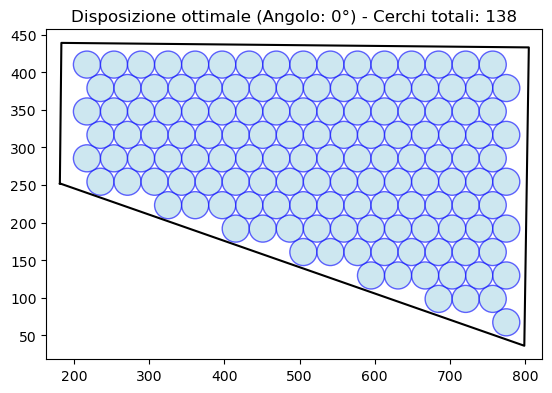

Rotazione migliore: 0°, Totale cerchi: 138
✅ Risultato esportato in 'polygon_with_circles.json'


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely import affinity
from shapely.ops import unary_union
import json


def generate_hex_grid(polygon: Polygon, radius: float, angle: float = 0):
    # Applica rotazione al poligono
    rotated_polygon = affinity.rotate(polygon, angle, origin='centroid')
    
    minx, miny, maxx, maxy = rotated_polygon.bounds

    dx = 2 * radius
    dy = np.sqrt(3) * radius

    points = []
    y = miny
    row = 0
    while y <= maxy:
        x = minx + (radius if row % 2 else 0)
        while x <= maxx:
            center = Point(x, y)
            if rotated_polygon.contains(center.buffer(radius)):
                points.append((x, y))
            x += dx
        y += dy
        row += 1

    # Ruota indietro i punti
    rotated_back = [affinity.rotate(Point(x, y), -angle, origin=polygon.centroid) for x, y in points]
    return [(p.x, p.y) for p in rotated_back]

def generate_aligned_hex_grid(polygon: Polygon, radius: float, margin=3):
    """Genera una griglia esagonale allineata per rettangoli/quadrati partendo dal bordo, con margine fisso."""
    # Trova il rettangolo ruotato minimo per considerare i rettangoli inclinati
    oriented_bbox = polygon.minimum_rotated_rectangle
    bbox_coords = list(oriented_bbox.exterior.coords)[:4]

    # Calcolo dell'angolo di rotazione del bounding box rispetto agli assi
    v1 = np.array(bbox_coords[1]) - np.array(bbox_coords[0])
    angle = np.degrees(np.arctan2(v1[1], v1[0]))

    # Ruota il poligono per allinearlo con gli assi
    aligned_polygon = affinity.rotate(polygon, -angle, origin='centroid')

    minx, miny, maxx, maxy = aligned_polygon.bounds
    dx = 2 * radius
    dy = np.sqrt(3) * radius

    # Calcolo del margine in coordinate
    margin_x = (maxx - minx) * (margin / 1000)  # Approssimazione per il margine
    margin_y = (maxy - miny) * (margin / 1000)

    points = []
    y = miny + radius + margin_y  # Partenza dal bordo inferiore con margine
    row = 0

    while y <= maxy - radius - margin_y:
        # Allineamento alla colonna sinistra con margine
        x = minx + (radius if row % 2 else 0) + margin_x
        while x <= maxx - radius - margin_x:
            center = Point(x, y)
            if aligned_polygon.contains(center.buffer(radius)):
                points.append((x, y))
            x += dx
        y += dy
        row += 1

    # Ruota indietro i punti per tornare alla posizione originale
    aligned_back = [affinity.rotate(Point(x, y), angle, origin=polygon.centroid) for x, y in points]
    return [(p.x, p.y) for p in aligned_back]


#metodo che controlla se un nuovo cerchio può essere aggiunto senza collisioni
def add_extra_circles(polygon: Polygon, existing_centers: list, radius: float, spacing: float = 0.5):
    minx, miny, maxx, maxy = polygon.bounds
    new_points = []

    # Crea i buffer dei cerchi esistenti per confronto geometrico
    existing_buffers = [Point(x, y).buffer(radius) for x, y in existing_centers]
    all_buffers = unary_union(existing_buffers)  # Unione dei cerchi già piazzati

    dx = spacing * radius
    dy = spacing * radius

    x_vals = np.arange(minx, maxx + dx, dx)
    y_vals = np.arange(miny, maxy + dy, dy)

    for x in x_vals:
        for y in y_vals:
            center = Point(x, y)
            buffer = center.buffer(radius)

            if not polygon.contains(buffer):
                continue

            # Controllo preciso: il nuovo cerchio non deve intersecare altri
            if all_buffers.intersects(buffer):
                continue

            # Aggiungilo e aggiorna unione
            new_points.append((x, y))
            all_buffers = unary_union([all_buffers, buffer])

    return new_points


def plot_packing(polygon: Polygon, centers: list, radius: float, title="Packing"):
    fig, ax = plt.subplots()
    x, y = polygon.exterior.xy
    ax.plot(x, y, color='black')

    for cx, cy in centers:
        circle = plt.Circle((cx, cy), radius, edgecolor='blue', facecolor='lightblue', alpha=0.6)
        ax.add_patch(circle)

    ax.set_aspect('equal')
    ax.set_xlim(polygon.bounds[0] - radius, polygon.bounds[2] + radius)
    ax.set_ylim(polygon.bounds[1] - radius, polygon.bounds[3] + radius)
    plt.title(f"{title} - Cerchi totali: {len(centers)}")
    plt.show()


#metodo che trova la rotazione ottimale per il packing
def find_best_rotation(polygon: Polygon, radius: float, angles=None):
    if angles is None:
        angles = np.arange(0, 62, 1)  # Rotazioni da 0° a 55° ogni 5°

    best_centers = []
    best_angle = 0

    for angle in angles:
        base_centers = generate_hex_grid(polygon, radius, angle=angle)
        extra_centers = add_extra_circles(polygon, base_centers, radius)
        total = base_centers + extra_centers

        print(f"Rotazione {angle}° -> Totale cerchi: {len(total)}")
        if len(total) > len(best_centers):
            best_centers = total
            best_angle = angle

    return best_centers, best_angle

def is_rectangle_or_square(polygon: Polygon, angle_tolerance=3.0, length_tolerance=1e-2):
    """Verifica se il poligono è un rettangolo o quadrato, anche se leggermente inclinato."""
    coords = list(polygon.exterior.coords)
    if len(coords) != 5:  # Un rettangolo ha 4 lati (più uno chiuso)
        return False

    # Calcolo delle lunghezze dei lati del poligono
    lengths = [np.linalg.norm(np.array(coords[i]) - np.array(coords[i + 1])) for i in range(4)]
    
    # Verifica che i lati opposti siano circa uguali
    if not (np.isclose(lengths[0], lengths[2], atol=length_tolerance) and
            np.isclose(lengths[1], lengths[3], atol=length_tolerance)):
        return False

    # Calcolo degli angoli tra i lati (deve essere circa 90°)
    for i in range(4):
        v1 = np.array(coords[i + 1]) - np.array(coords[i])
        v2 = np.array(coords[(i + 2) % 4]) - np.array(coords[i + 1])
        angle = np.degrees(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))
        if not np.isclose(angle, 90, atol=angle_tolerance):
            return False

    return True

def find_best_packing(polygon: Polygon, radius: float):
    """Sceglie il miglior metodo di packing a seconda della forma."""
    if is_rectangle_or_square(polygon):
        print("🟦 Rilevato rettangolo/quadrato: uso griglia esagonale allineata al bordo.")
        best_centers = generate_aligned_hex_grid(polygon, radius)
        best_angle = 0
    else:
        print("🔄 Forma irregolare: uso disposizione esagonale con rotazione ottimizzata.")
        best_centers, best_angle = find_best_rotation(polygon, radius)
    
    return best_centers, best_angle


if __name__ == "__main__":
    # Carica i punti
    with open("polygon.json", "r") as f:
        vertices = json.load(f)

    x, y = zip(*vertices)
    poly = Polygon(vertices)

    circle_radius = 18

    # Trova la miglior disposizione con il metodo adattivo
    best_centers, best_angle = find_best_packing(poly, circle_radius)

    # Visualizza il risultato
    plot_packing(poly, best_centers, circle_radius, title=f"Disposizione ottimale (Angolo: {best_angle}°)")
    print(f"Rotazione migliore: {best_angle}°, Totale cerchi: {len(best_centers)}")

    # Salva il risultato
    export_data = {
        "polygon": vertices,
        "circles": [
            {"center": [x, y], "radius": circle_radius}
            for x, y in best_centers
        ]
    }

    with open("polygon_with_circles.json", "w") as f:
        json.dump(export_data, f, indent=2)

    print("✅ Risultato esportato in 'polygon_with_circles.json'")

In [9]:
def trova_tutte_configurazioni(celle_totali, v_cella=3.6, ah_cella=2.5):
    configurazioni = []

    for s in range(1, celle_totali + 1):
        if celle_totali % s != 0:
            continue  # solo configurazioni intere
        p = celle_totali // s
        v_tot = s * v_cella
        ah_tot = p * ah_cella
        configurazioni.append((s, p, v_tot, ah_tot))

    if not configurazioni:
        raise ValueError("Nessuna configurazione valida trovata")

    # Massima tensione
    max_tensione = max(configurazioni, key=lambda x: x[2])

    # Massima capacità
    max_capacita = max(configurazioni, key=lambda x: x[3])

    # Bilanciata (tensione ≈ capacità in termini assoluti)
    bilanciata = min(configurazioni, key=lambda x: abs(x[2] - x[3]))

    return {
        "massima_tensione": max_tensione,
        "massima_capacita": max_capacita,
        "bilanciata": bilanciata
    }

def stampa_configurazioni(configs):
    for nome, (s, p, v, ah) in configs.items():
        label = {
            "massima_tensione": "Massima Tensione",
            "massima_capacita": "Massima Capacità",
            "bilanciata": "Bilanciata"
        }[nome]
        print(f"{label}: {s}S{p}P  →  {v:.2f} V, {ah:.2f} Ah")

# Esempio d'uso
if __name__ == "__main__":
    celle_totali = 138  # puoi cambiarlo
    configs = trova_tutte_configurazioni(celle_totali)
    stampa_configurazioni(configs)

Massima Tensione: 138S1P  →  496.80 V, 2.50 Ah
Massima Capacità: 1S138P  →  3.60 V, 345.00 Ah
Bilanciata: 6S23P  →  21.60 V, 57.50 Ah


✅ Layout salvato in layout.json


/var/folders/20/448h2f1933x4jpn5p3l2lb7c0000gn/T/ipykernel_18894/478838950.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(gruppi))


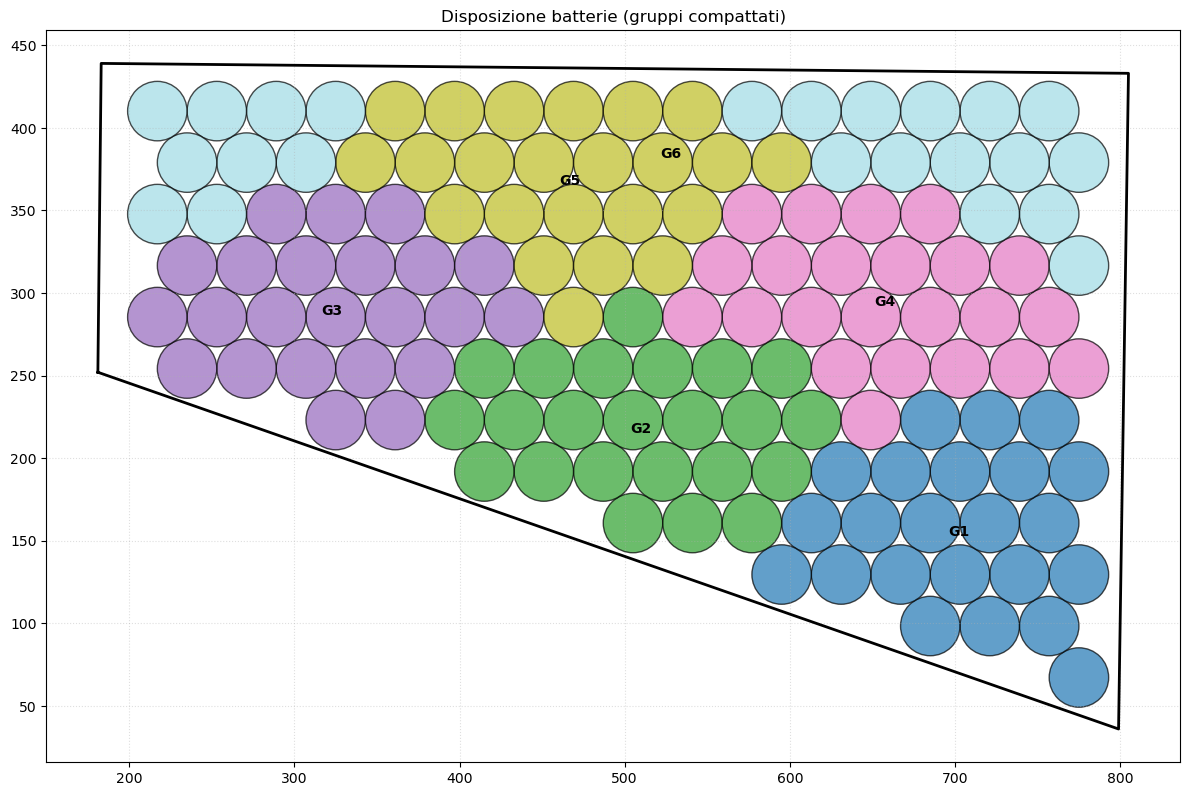

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from pathlib import Path

##############################################################
# 1. CONFIGURATION & UTILITIES                               #
##############################################################

DIST_FACTOR = 3.0  # multiplier of radius used to judge adjacency


def calcola_configurazione_batteria(v_cella: float, ah_cella: float,
                                   v_target: float, ah_target: float,
                                   celle_disponibili: int):
    """Calcola la configurazione serie/parallelo più vicina al target.

    Restituisce (S, P, totale_celle)
    """
    s = round(v_target / v_cella)
    p = round(ah_target / ah_cella)
    totale = s * p

    print(f"Configurazione suggerita: {s}S{p}P  (totale: {totale} celle)")
    if totale <= celle_disponibili:
        print("✅ Le celle entrano nella forma disponibile.")
    else:
        print("⚠️ Troppe celle. Considera di abbassare la capacità o cambiare disposizione.")
    return s, p, totale


##############################################################
# 2. PRE‑PROCESSING                                          #
##############################################################

def build_adjacency(centers: list[tuple[float, float]], radius: float) -> nx.Graph:
    """Costruisce un grafo di adiacenza basato sulla distanza euclidea."""
    G = nx.Graph()
    for i, c1 in enumerate(centers):
        for j in range(i + 1, len(centers)):
            if np.linalg.norm(np.subtract(c1, centers[j])) <= DIST_FACTOR * radius:
                G.add_edge(i, j)
    return G


def elimina_celle_in_eccesso(centers: list[tuple[float, float]], required: int, radius: float):
    """Mantiene la componente più grande e rimuove celle finché ne restano 'required'."""

    if len(centers) <= required:
        return centers

    G = build_adjacency(centers, radius)
    largest = max(nx.connected_components(G), key=len)
    kept = list(largest)

    # se servono comunque meno celle, rimuovi quelle col minor grado (meno collegate)
    while len(kept) > required:
        degs = [(n, G.degree[n]) for n in kept]
        worst = min(degs, key=lambda x: x[1])[0]
        kept.remove(worst)

    return [centers[i] for i in kept]


##############################################################
# 3. CREAZIONE GRUPPI (CONTIGUI & QUASI‑RETTANGOLARI)        #
##############################################################

def _bounding_box_area(points: list[tuple[float, float]]):
    xs, ys = zip(*points)
    return (max(xs) - min(xs)) * (max(ys) - min(ys))


def crea_gruppi_regolari(centers: list[tuple[float, float]], S: int, P: int, radius: float):
    """Former gruppi contigui usando BFS sull'adiacenza.

    Il criterio di scelta dei vicini mira a minimizzare l'area del
    bounding‑box del gruppo (più rettangolare = area ridotta).
    """
    G = build_adjacency(centers, radius)
    used: set[int] = set()
    idx_sorted = sorted(range(len(centers)), key=lambda i: (centers[i][1], centers[i][0]))
    gruppi: list[list[tuple[float, float]]] = []

    for seed in idx_sorted:
        if seed in used:
            continue
        group_idx = [seed]
        frontier = [seed]
        used.add(seed)

        # BFS fino a raggiungere P celle
        while frontier and len(group_idx) < P:
            current = frontier.pop(0)
            neighbors = [n for n in G.neighbors(current) if n not in used]
            # Ordina i vicini per distanza dal seed → compattare
            neighbors.sort(key=lambda n: np.linalg.norm(np.subtract(centers[n], centers[seed])))
            for n in neighbors:
                group_idx.append(n)
                used.add(n)
                frontier.append(n)
                if len(group_idx) == P:
                    break

        # Se per qualche ragione non abbiamo abbastanza vicini, prendiamo i più vicini restanti
        if len(group_idx) < P:
            rest = [i for i in idx_sorted if i not in used]
            rest.sort(key=lambda n: np.linalg.norm(np.subtract(centers[n], centers[seed])))
            for n in rest[: P - len(group_idx)]:
                group_idx.append(n)
                used.add(n)

        gruppi.append([centers[i] for i in group_idx])
        if len(gruppi) == S:
            break

    # Se non abbiamo abbastanza gruppi (può succedere se la componente non è abbastanza grande)
    while len(gruppi) < S:
        gruppi.append([])

    return gruppi


##############################################################
# 4. VISUALIZZAZIONE                                         #
##############################################################

def visualizza_gruppi(polygon: list[tuple[float, float]], gruppi: list[list[tuple[float, float]]], radius: float):
    fig, ax = plt.subplots(figsize=(12, 8))
    x_poly, y_poly = zip(*polygon)
    ax.plot(x_poly, y_poly, "k-", linewidth=2)

    cmap = plt.cm.get_cmap("tab20", len(gruppi))
    for gid, gruppo in enumerate(gruppi):
        for (x, y) in gruppo:
            circ = plt.Circle((x, y), radius, color=cmap(gid), ec="black", alpha=0.7)
            ax.add_patch(circ)
        if gruppo:  # etichetta il centro del gruppo
            gx, gy = np.mean([p[0] for p in gruppo]), np.mean([p[1] for p in gruppo])
            ax.text(gx, gy, f"G{gid+1}", ha="center", va="center", fontsize=10, weight="bold")

    ax.set_aspect("equal")
    ax.set_title("Disposizione batterie (gruppi compattati)")
    ax.grid(True, linestyle=":", alpha=0.4)
    plt.tight_layout()
    plt.show()


##############################################################
# 5. MAIN                                                    #
##############################################################

def main(json_path="polygon_with_circles.json", output_path="layout.json"):
    S=6
    P=23

    # Carica dati
    data = json.loads(Path(json_path).read_text())
    centers = [tuple(c["center"]) for c in data["circles"]]
    radius = data["circles"][0]["radius"]

    # Elimina celle in eccesso mantenendo la componente principale più densa
    needed = S * P
    centers = elimina_celle_in_eccesso(centers, needed, radius)

    # Crea gruppi regolari & contigui
    gruppi = crea_gruppi_regolari(centers, S, P, radius)

    # Salva risultato
    out = {
        "polygon": data["polygon"],
        "circles": [{"center": list(c), "radius": radius} for c in centers],
        "gruppi": gruppi,
    }
    Path(output_path).write_text(json.dumps(out, indent=2))
    print(f"✅ Layout salvato in {output_path}")

    # Visualizza
    visualizza_gruppi(data["polygon"], gruppi, radius)


if __name__ == "__main__":
    main()


Configurazione suggerita: 9S12P  (108 celle)
✅ Celle sufficienti.
✅ Layout salvato in layout.json


/var/folders/20/448h2f1933x4jpn5p3l2lb7c0000gn/T/ipykernel_2646/1969208242.py:193: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(gruppi_coord))


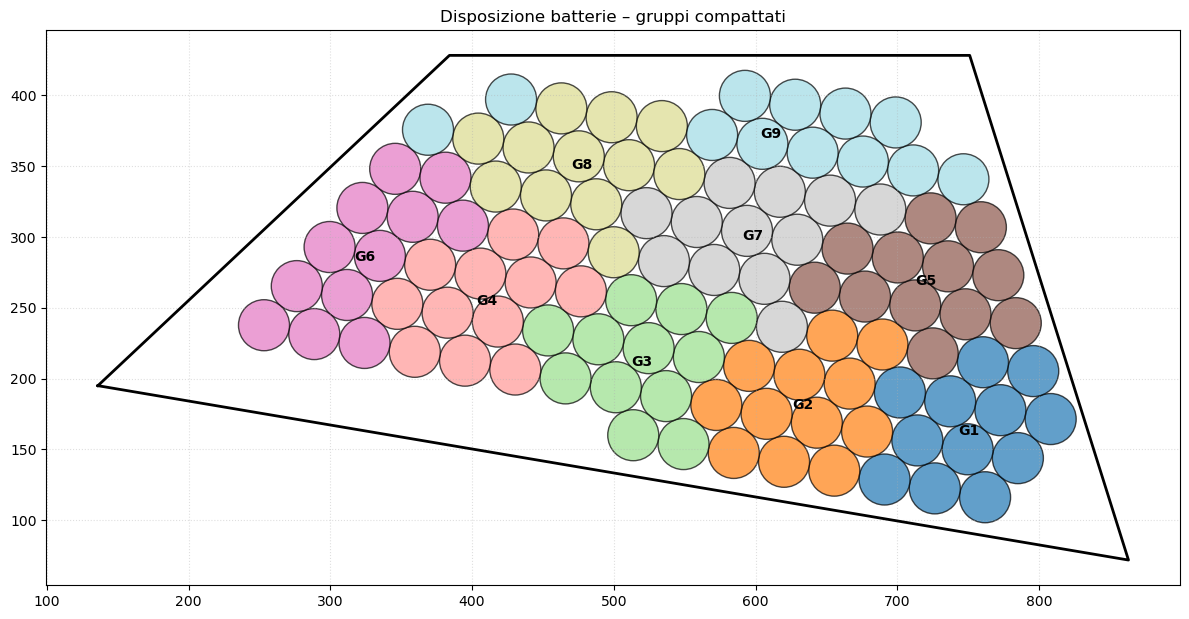

In [58]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#######################################################################
# 1. CONFIGURATION                                                    #
#######################################################################

DIST_FACTOR = 3.5          # distanza di adiacenza = DIST_FACTOR · radius

#######################################################################
# 2. UTILITY                                                          #
#######################################################################

def calcola_configurazione_batteria(v_cella, ah_cella,
                                    v_target, ah_target,
                                    celle_disponibili):
    s = round(v_target / v_cella)
    p = round(ah_target / ah_cella)
    tot = s * p
    print(f"Configurazione suggerita: {s}S{p}P  ({tot} celle)")
    if tot <= celle_disponibili:
        print("✅ Celle sufficienti.")
    else:
        print("⚠️ Troppe celle, rivedere il target.")
    return s, p, tot


def build_adjacency_fast(centers, radius) -> nx.Graph:
    """Grafo di adiacenza con nodi = indici (più semplice & veloce)."""
    pts = np.asarray(centers)
    D = np.linalg.norm(pts[:, None, :] - pts[None, :, :], axis=-1)
    mask = (D <= DIST_FACTOR * radius) & (D > 0)

    G = nx.Graph()
    for i in range(len(centers)):
        js = np.nonzero(mask[i])[0]
        G.add_edges_from((i, int(j)) for j in js)
    return G


def elimina_celle_in_eccesso(centers, required, radius):
    if len(centers) <= required:
        return centers

    G = build_adjacency_fast(centers, radius)
    main = max(nx.connected_components(G), key=len)
    kept = list(main)

    while len(kept) > required:
        worst = min(kept, key=G.degree.__getitem__)
        kept.remove(worst)

    return [centers[i] for i in kept]

#######################################################################
# 3. GRUPPI INIZIALI (liste di INDICI)                                #
#######################################################################

def crea_gruppi_regolari(centers, S, P, radius, G):
    used = set()
    order = sorted(range(len(centers)), key=lambda i: (centers[i][1], centers[i][0]))
    gruppi_idx = []

    for seed in order:
        if seed in used:
            continue
        group = [seed]
        queue = [seed]
        used.add(seed)

        while queue and len(group) < P:
            cur = queue.pop(0)
            neigh = [n for n in G.neighbors(cur) if n not in used]
            neigh.sort(key=lambda n: np.linalg.norm(np.subtract(centers[n], centers[seed])))
            for n in neigh:
                group.append(n); used.add(n); queue.append(n)
                if len(group) == P:
                    break

        if len(group) < P:                         # riempimento con i più vicini rimasti
            rest = [i for i in order if i not in used]
            rest.sort(key=lambda n: np.linalg.norm(np.subtract(centers[n], centers[seed])))
            for n in rest[: P - len(group)]:
                group.append(n); used.add(n)

        gruppi_idx.append(group)
        if len(gruppi_idx) == S:
            break

    while len(gruppi_idx) < S:                     # in caso di mancanza nodi
        gruppi_idx.append([])

    return gruppi_idx

#######################################################################
# 4. RIPULITURA “SCHEGGE”                                              #
#######################################################################

def _is_connected(nodes: list[int], G: nx.Graph) -> bool:
    """Ritorna True se tutti i nodi sono in un’unica componente connessa."""
    if len(nodes) <= 1:          # 0-1 nodi è comunque “connesso”
        return True
    sub = G.subgraph(nodes)
    return nx.is_connected(sub)

def refine_groups(gruppi: list[list[int]],
                  P: int,
                  G: nx.Graph,
                  centers: list[tuple[float, float]],
                  max_pass: int = 8) -> list[list[int]]:
    """Elimina ‘schegge’ scambiandole con celle adiacenti del gruppo vicino.

    – una ‘scheggia’ è una cella non nello stesso componente connesso
      del corpo principale del proprio gruppo;
    – si cerca un gruppo adiacente (con un lato in comune) che abbia
      una cella da scambiare;
    – lo scambio è accettato solo se **dopo** entrambi i gruppi risultano
      connessi (o migliorano il numero di componenti).
    """
    # mappa cella → gruppo
    cell2g = {idx: gi for gi, g in enumerate(gruppi) for idx in g}

    made_changes = True
    n_pass = 0
    while made_changes and n_pass < max_pass:
        made_changes = False
        n_pass += 1

        for gi, gruppo in enumerate(gruppi):
            if _is_connected(gruppo, G):
                continue                # già coeso

            # componente “corpo” più grande
            comps = list(nx.connected_components(G.subgraph(gruppo)))
            main_comp = max(comps, key=len)
            outliers  = [c for c in gruppo if c not in main_comp]

            for cell in outliers:
                # gruppi adiacenti alla scheggia
                vicino_groups = {cell2g[n] for n in G.neighbors(cell)
                                 if cell2g[n] != gi}

                # valuta ogni gruppo vicino
                for gj in vicino_groups:
                    # scegli una candidata da gj il più possibile vicina al corpo di gi
                    cand_cells = [n for n in gruppi[gj]
                                  if any(G.has_edge(n, m) for m in main_comp)]
                    if not cand_cells:
                        continue

                    # ordinale per distanza geometrica dal centroide del corpo
                    cx, cy = np.mean([centers[m][0] for m in main_comp]), \
                             np.mean([centers[m][1] for m in main_comp])
                    cand_cells.sort(key=lambda n:
                                    np.hypot(centers[n][0] - cx,
                                             centers[n][1] - cy))

                    for donor in cand_cells:
                        # swap “cell” ↔ donor (prova virtualmente)
                        grp_i_new = [x for x in gruppi[gi] if x != cell] + [donor]
                        grp_j_new = [x for x in gruppi[gj] if x != donor] + [cell]

                        # capienza rispettata?
                        if len(grp_i_new) > P or len(grp_j_new) > P:
                            continue

                        # accetta se entrambi i gruppi diventano (o restano) connessi
                        if _is_connected(grp_i_new, G) and _is_connected(grp_j_new, G):
                            gruppi[gi] = grp_i_new
                            gruppi[gj] = grp_j_new
                            cell2g[cell]  = gj
                            cell2g[donor] = gi
                            made_changes = True
                            break     # fine donor-loop
                    if made_changes:
                        break         # fine gj-loop
            # fine for cell
        # fine per gi
    return gruppi

#######################################################################
# 5. VISUALIZZAZIONE (usa coordinate)                                  #
#######################################################################

def visualizza_gruppi(polygon, gruppi_coord, radius):
    fig, ax = plt.subplots(figsize=(12, 8))
    px, py = zip(*polygon)
    ax.plot(px, py, "k-", lw=2)

    cmap = plt.cm.get_cmap("tab20", len(gruppi_coord))
    for gid, gruppo in enumerate(gruppi_coord):
        for x, y in gruppo:
            ax.add_patch(plt.Circle((x, y), radius, color=cmap(gid), ec="black", alpha=0.7))
        if gruppo:
            gx, gy = np.mean([p[0] for p in gruppo]), np.mean([p[1] for p in gruppo])
            ax.text(gx, gy, f"G{gid+1}", ha="center", va="center", weight="bold")
    ax.set_aspect("equal"); ax.grid(ls=":", alpha=0.4)
    ax.set_title("Disposizione batterie – gruppi compattati")
    plt.tight_layout(); plt.show()

#######################################################################
# 6. MAIN                                                              #
#######################################################################

def main(json_path="polygon_with_circles.json", output_path="layout.json"):
    # config batterie
    S, P, _ = calcola_configurazione_batteria(
        v_cella=3.6, ah_cella=2.5, v_target=32.40, ah_target=30, celle_disponibili=108)

    # dati
    data = json.loads(Path(json_path).read_text())
    centers = [tuple(c["center"]) for c in data["circles"]]
    radius  = data["circles"][0]["radius"]

    # pruning celle
    centers = elimina_celle_in_eccesso(centers, S * P, radius)

    # grafo unico
    G = build_adjacency_fast(centers, radius)

    # gruppi indici + raffinatura
    gruppi_idx = crea_gruppi_regolari(centers, S, P, radius, G)
    gruppi_idx = refine_groups(gruppi_idx, P, G, centers)

    # traduci in coordinate per output / plot
    gruppi_coord = [[centers[i] for i in g] for g in gruppi_idx]

    # salva
    Path(output_path).write_text(json.dumps({
        "polygon": data["polygon"],
        "circles": [{"center": list(c), "radius": radius} for c in centers],
        "gruppi": gruppi_coord
    }, indent=2))
    print(f"✅ Layout salvato in {output_path}")

    # mostra
    visualizza_gruppi(data["polygon"], gruppi_coord, radius)


if __name__ == "__main__":
    main()

Configurazione suggerita: 13S9P  (117 celle)
✅ Celle sufficienti.
✅ Layout salvato in layout.json


/var/folders/20/448h2f1933x4jpn5p3l2lb7c0000gn/T/ipykernel_2646/240162261.py:194: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(gruppi_coord))


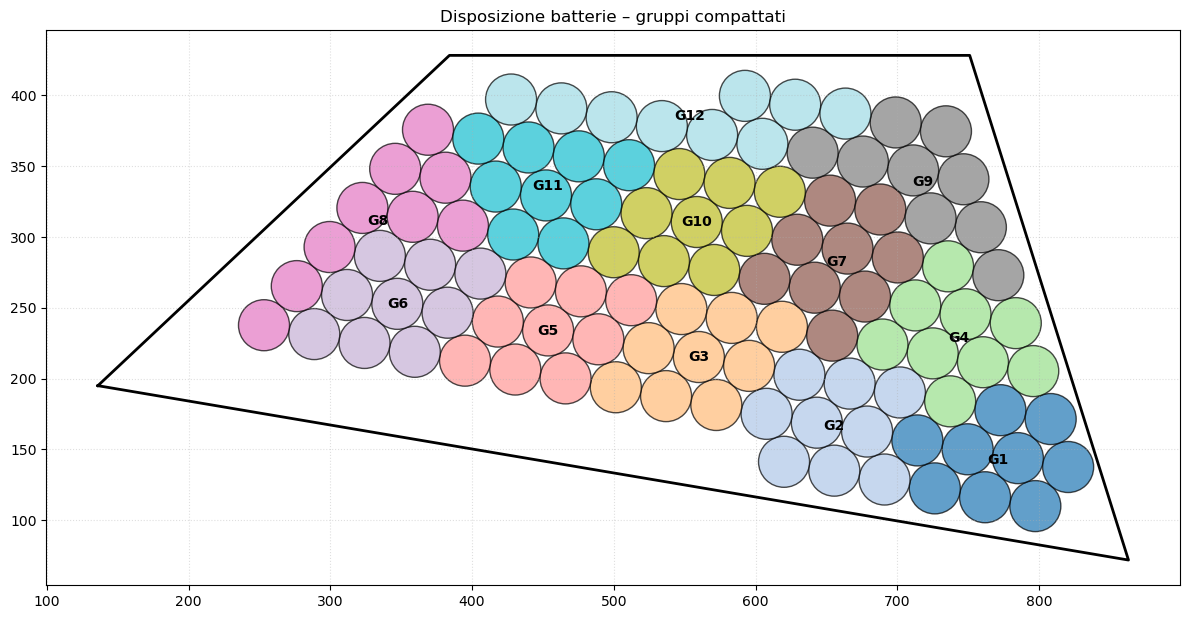

In [65]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#######################################################################
# 1. CONFIGURATION                                                    #
#######################################################################

DIST_FACTOR = 3.0          # distanza di adiacenza = DIST_FACTOR · radius

#######################################################################
# 2. UTILITY                                                          #
#######################################################################

def calcola_configurazione_batteria(v_cella, ah_cella,
                                    v_target, ah_target,
                                    celle_disponibili):
    s = round(v_target / v_cella)
    p = round(ah_target / ah_cella)
    tot = s * p
    print(f"Configurazione suggerita: {s}S{p}P  ({tot} celle)")
    if tot <= celle_disponibili:
        print("✅ Celle sufficienti.")
    else:
        print("⚠️ Troppe celle, rivedere il target.")
    return s, p, tot


def build_adjacency_fast(centers, radius) -> nx.Graph:
    """Grafo di adiacenza con nodi = indici (più semplice & veloce)."""
    pts = np.asarray(centers)
    D = np.linalg.norm(pts[:, None, :] - pts[None, :, :], axis=-1)
    mask = (D <= DIST_FACTOR * radius) & (D > 0)

    G = nx.Graph()
    for i in range(len(centers)):
        js = np.nonzero(mask[i])[0]
        G.add_edges_from((i, int(j)) for j in js)
    return G


def elimina_celle_in_eccesso(centers, required, radius):
    if len(centers) <= required:
        return centers

    G = build_adjacency_fast(centers, radius)
    main = max(nx.connected_components(G), key=len)
    kept = list(main)

    while len(kept) > required:
        worst = min(kept, key=G.degree.__getitem__)
        kept.remove(worst)

    return [centers[i] for i in kept]

#######################################################################
# 3. GRUPPI INIZIALI (liste di INDICI)                                #
#######################################################################

def crea_gruppi_regolari(centers, S, P, radius, G):
    used = set()
    order = sorted(range(len(centers)), key=lambda i: (centers[i][1], centers[i][0]))
    gruppi_idx = []

    for seed in order:
        if seed in used:
            continue
        group = [seed]
        queue = [seed]
        used.add(seed)

        while queue and len(group) < P:
            cur = queue.pop(0)
            neigh = [n for n in G.neighbors(cur) if n not in used]
            cx, cy = np.mean([centers[k] for k in group], axis=0)
            neigh.sort(key=lambda n: (abs(centers[n][0]-cx) + abs(centers[n][1]-cy)))
            for n in neigh:
                group.append(n); used.add(n); queue.append(n)
                if len(group) == P:
                    break

        if len(group) < P:                         # riempimento con i più vicini rimasti
            rest = [i for i in order if i not in used]
            rest.sort(key=lambda n: np.linalg.norm(np.subtract(centers[n], centers[seed])))
            for n in rest[: P - len(group)]:
                group.append(n); used.add(n)

        gruppi_idx.append(group)
        if len(gruppi_idx) == S:
            break

    while len(gruppi_idx) < S:                     # in caso di mancanza nodi
        gruppi_idx.append([])

    return gruppi_idx

#######################################################################
# 4. RIPULITURA “SCHEGGE”                                              #
#######################################################################

def _is_connected(nodes: list[int], G: nx.Graph) -> bool:
    """Ritorna True se tutti i nodi sono in un’unica componente connessa."""
    if len(nodes) <= 1:          # 0-1 nodi è comunque “connesso”
        return True
    sub = G.subgraph(nodes)
    return nx.is_connected(sub)

def refine_groups(gruppi: list[list[int]],
                  P: int,
                  G: nx.Graph,
                  centers: list[tuple[float, float]],
                  max_pass: int = 8) -> list[list[int]]:
    """Elimina ‘schegge’ scambiandole con celle adiacenti del gruppo vicino.

    – una ‘scheggia’ è una cella non nello stesso componente connesso
      del corpo principale del proprio gruppo;
    – si cerca un gruppo adiacente (con un lato in comune) che abbia
      una cella da scambiare;
    – lo scambio è accettato solo se **dopo** entrambi i gruppi risultano
      connessi (o migliorano il numero di componenti).
    """
    # mappa cella → gruppo
    cell2g = {idx: gi for gi, g in enumerate(gruppi) for idx in g}

    made_changes = True
    n_pass = 0
    while made_changes and n_pass < max_pass:
        made_changes = False
        n_pass += 1

        for gi, gruppo in enumerate(gruppi):
            if _is_connected(gruppo, G):
                continue                # già coeso

            # componente “corpo” più grande
            comps = list(nx.connected_components(G.subgraph(gruppo)))
            main_comp = max(comps, key=len)
            outliers  = [c for c in gruppo if c not in main_comp]

            for cell in outliers:
                # gruppi adiacenti alla scheggia
                vicino_groups = {cell2g[n] for n in G.neighbors(cell)
                                 if cell2g[n] != gi}

                # valuta ogni gruppo vicino
                for gj in vicino_groups:
                    # scegli una candidata da gj il più possibile vicina al corpo di gi
                    cand_cells = [n for n in gruppi[gj]
                                  if any(G.has_edge(n, m) for m in main_comp)]
                    if not cand_cells:
                        continue

                    # ordinale per distanza geometrica dal centroide del corpo
                    cx, cy = np.mean([centers[m][0] for m in main_comp]), \
                             np.mean([centers[m][1] for m in main_comp])
                    cand_cells.sort(key=lambda n:
                                    np.hypot(centers[n][0] - cx,
                                             centers[n][1] - cy))

                    for donor in cand_cells:
                        # swap “cell” ↔ donor (prova virtualmente)
                        grp_i_new = [x for x in gruppi[gi] if x != cell] + [donor]
                        grp_j_new = [x for x in gruppi[gj] if x != donor] + [cell]

                        # capienza rispettata?
                        if len(grp_i_new) > P or len(grp_j_new) > P:
                            continue

                        # accetta se entrambi i gruppi diventano (o restano) connessi
                        if _is_connected(grp_i_new, G) and _is_connected(grp_j_new, G):
                            gruppi[gi] = grp_i_new
                            gruppi[gj] = grp_j_new
                            cell2g[cell]  = gj
                            cell2g[donor] = gi
                            made_changes = True
                            break     # fine donor-loop
                    if made_changes:
                        break         # fine gj-loop
            # fine for cell
        # fine per gi
    return gruppi

#######################################################################
# 5. VISUALIZZAZIONE (usa coordinate)                                  #
#######################################################################

def visualizza_gruppi(polygon, gruppi_coord, radius):
    fig, ax = plt.subplots(figsize=(12, 8))
    px, py = zip(*polygon)
    ax.plot(px, py, "k-", lw=2)

    cmap = plt.cm.get_cmap("tab20", len(gruppi_coord))
    for gid, gruppo in enumerate(gruppi_coord):
        for x, y in gruppo:
            ax.add_patch(plt.Circle((x, y), radius, color=cmap(gid), ec="black", alpha=0.7))
        if gruppo:
            gx, gy = np.mean([p[0] for p in gruppo]), np.mean([p[1] for p in gruppo])
            ax.text(gx, gy, f"G{gid+1}", ha="center", va="center", weight="bold")
    ax.set_aspect("equal"); ax.grid(ls=":", alpha=0.4)
    ax.set_title("Disposizione batterie – gruppi compattati")
    plt.tight_layout(); plt.show()

#######################################################################
# 6. MAIN                                                              #
#######################################################################

def main(json_path="polygon_with_circles.json", output_path="layout.json"):
    # config batterie
    S, P, _ = calcola_configurazione_batteria(
        v_cella=3.6, ah_cella=2.5, v_target=47, ah_target=22, celle_disponibili=117)
    
    S=12
    P=9

    # dati
    data = json.loads(Path(json_path).read_text())
    centers = [tuple(c["center"]) for c in data["circles"]]
    radius  = data["circles"][0]["radius"]

    # pruning celle
    centers = elimina_celle_in_eccesso(centers, S * P, radius)

    # grafo unico
    G = build_adjacency_fast(centers, radius)

    # gruppi indici + raffinatura
    gruppi_idx = crea_gruppi_regolari(centers, S, P, radius, G)
    gruppi_idx = refine_groups(gruppi_idx, P, G, centers)

    # traduci in coordinate per output / plot
    gruppi_coord = [[centers[i] for i in g] for g in gruppi_idx]

    # salva
    Path(output_path).write_text(json.dumps({
        "polygon": data["polygon"],
        "circles": [{"center": list(c), "radius": radius} for c in centers],
        "gruppi": gruppi_coord
    }, indent=2))
    print(f"✅ Layout salvato in {output_path}")

    # mostra
    visualizza_gruppi(data["polygon"], gruppi_coord, radius)


if __name__ == "__main__":
    main()

In [ ]:
# ----------------------------------------------------------
# 0. dipendenze
# pip install "spopt>=0.4,<0.7" libpysal networkx
# ----------------------------------------------------------
import json, math, random
from pathlib import Path

import numpy as np, libpysal, networkx as nx
import matplotlib.pyplot as plt
from   spopt.region import RandomRegion

DIST_FACTOR = 3.0          # raggio di adiacenza = DIST_FACTOR * radius
# pesi della funzione-obiettivo di forma (più basso = migliore)
ALPHA = 1.0 ; BETA = 1.0 ; GAMMA = 1.0                                    ### NEW

# ----------------------------------------------------------
# 1. costruzione grafo di adiacenza
# ----------------------------------------------------------
def build_graph(centers, r):
    pts  = np.asarray(centers)
    dmat = np.linalg.norm(pts[:, None] - pts[None, :], axis=-1)
    mask = (dmat > 0) & (dmat <= DIST_FACTOR * r)
    G = nx.Graph()
    for i in range(len(centers)):
        for j in np.where(mask[i])[0]:
            G.add_edge(i, int(j))
    return G

def graph_to_weights(G):
    return libpysal.weights.W({i: list(G.neighbors(i)) for i in G.nodes})

# ----------------------------------------------------------
# 2. metrica di “rettangularità”  e funzioni di utilità      ### NEW
# ----------------------------------------------------------
def shape_cost(group, centers, r):
    xs, ys = zip(*[centers[i] for i in group])
    w = max(xs) - min(xs) + 2*r
    h = max(ys) - min(ys) + 2*r
    perim = 2*(w+h)
    area  = w*h
    axis_ratio = max(w, h) / min(w, h)
    cx, cy = np.mean(xs), np.mean(ys)
    inertia = np.mean([(x-cx)**2 + (y-cy)**2 for x, y in zip(xs, ys)])
    return (ALPHA * perim/math.sqrt(area)
          +  BETA  * (axis_ratio - 1)
          +  GAMMA * inertia)

def _is_conn(nodes, G):
    return len(nodes) <= 1 or nx.is_connected(G.subgraph(nodes))

# ----------------------------------------------------------
# 3. local-search per migliorare la forma dei cluster        ### NEW
# ----------------------------------------------------------
def improve_shapes(groups, P, centers, G, r, max_iter=600):
    cell2g = {i: gi for gi, g in enumerate(groups) for i in g}

    for _ in range(max_iter):
        improved = False
        ranked = sorted(range(len(groups)),
                        key=lambda gi: shape_cost(groups[gi], centers, r),
                        reverse=True)           # dal peggiore al migliore
        for gi in ranked:
            for c in tuple(groups[gi]):         # copia perché potremmo togliere elementi
                neigh_gj = {cell2g[n] for n in G.neighbors(c) if cell2g[n] != gi}
                for gj in neigh_gj:
                    donors = [d for d in groups[gj]
                              if any(cell2g[n] == gi for n in G.neighbors(d))]
                    donors.sort(key=lambda n: G.degree[n], reverse=True)
                    for d in donors:
                        if c == d: continue
                        # swap virtuale
                        groups[gi].remove(c); groups[gi].append(d)
                        groups[gj].remove(d); groups[gj].append(c)
                        ok = _is_conn(groups[gi], G) and _is_conn(groups[gj], G)
                        better = (shape_cost(groups[gi], centers, r) +
                                  shape_cost(groups[gj], centers, r) <
                                  shape_cost(groups[gi]+[c], centers, r) +
                                  shape_cost(groups[gj]+[d], centers, r))
                        if ok and better:
                            cell2g[c], cell2g[d] = gj, gi
                            improved = True
                            break
                        # ripristina
                        groups[gi].remove(d); groups[gi].append(c)
                        groups[gj].remove(c); groups[gj].append(d)
                    if improved: break
                if improved: break
            if improved: break
        if not improved:
            break
    return groups
# ----------------------------------------------------------
# 4. algoritmo principale (spopt 0.6.x) – *uguale a prima*   #
# ----------------------------------------------------------
def regionalize(centers, r, S, P, seed=0, max_attempts=50):
    ids = list(range(len(centers)))
    W_dict = {i: [] for i in ids}
    for i, c1 in enumerate(centers):
        for j, c2 in enumerate(centers):
            if i != j and np.linalg.norm(np.subtract(c1, c2)) <= DIST_FACTOR * r:
                W_dict[i].append(j)
    W = libpysal.weights.W(W_dict)

    cards = [P] * S
    np.random.seed(seed)

    for _ in range(max_attempts):
        rr = RandomRegion(
            area_ids   = ids,
            num_regions= S,
            cardinality= cards,
            contiguity = W,
            maxiter    = 500,
            compact    = True
        )
        if rr.feasible:
            return rr.regions
    raise RuntimeError("Impossibile trovare un partizionamento S×P contiguo.")

# ----------------------------------------------------------
# 5. plotting (opzionale)
# ----------------------------------------------------------
def plot(poly, groups, centers, r):
    fig, ax = plt.subplots(figsize=(10, 7))
    x, y = zip(*poly); ax.plot(x, y, "k-", lw=2)
    cmap = plt.cm.get_cmap("tab20", len(groups))
    for gi, g in enumerate(groups):
        for i in g:
            ax.add_patch(plt.Circle(centers[i], r, color=cmap(gi), ec="k"))
        cx = np.mean([centers[i][0] for i in g])
        cy = np.mean([centers[i][1] for i in g])
        ax.text(cx, cy, f"G{gi+1}", ha="center", va="center")
    ax.set_aspect("equal"); ax.grid(ls=":"); plt.tight_layout(); plt.show()

# ----------------------------------------------------------
# 6. main
# ----------------------------------------------------------
def main(inp="polygon_with_circles.json",
         out="layout.json",
         v_cell=3.6, ah_cell=2.5,      # dati batteria
         v_tgt =32.4, ah_tgt =32.5,    # 9 S, 12 P
         show=True):

    data    = json.loads(Path(inp).read_text())
    centers = [tuple(c["center"]) for c in data["circles"]]
    r       = data["circles"][0]["radius"]

    S = round(v_tgt / v_cell)
    P = round(ah_tgt / ah_cell)
    assert S * P == len(centers), "Numero di celle ≠ S×P!"

    # partizionamento contiguo (spopt)
    groups  = regionalize(centers, r, S, P)

    # grafico di adiacenza per la fase di miglioramento
    G = build_graph(centers, r)
    groups = improve_shapes(groups, P, centers, G, r)                ### NEW

    # controllo finale
    assert len(groups)==S and all(len(g)==P for g in groups)

    # salva
    Path(out).write_text(json.dumps({
        "polygon": data["polygon"],
        "circles": data["circles"],
        "gruppi" : [[centers[i] for i in g] for g in groups]
    }, indent=2))
    print("✅  Layout salvato in", out)

    if show:
        plot(data["polygon"], groups, centers, r)

# ----------------------------------------------------------
if __name__ == "__main__":
    main()

ValueError: Number of areas (125) does not match `cardinality` (117).

GPT-o3

In [41]:
"""
Raggruppa cerchi in S gruppi contigui da P elementi con forma il più regolare
possibile, funzionando bene anche in poligoni irregolari.

ALGORITMO (sintesi)
──────────────────
1. *Peeling* del convesso per buttare via cerchi in eccesso mantenendo un blocco
   unico.
2. Costruzione del grafo di adiacenza (distanza ≤ 1.35·2·radius).
3. **Selezione seed** – farthest-point-sampling: scegli il cerchio con y minima
   e poi ripeti prendendo il nodo che massimizza la distanza minima dai seed già
   scelti. Si ottengono S semi lontani fra loro → gruppi distribuiti.
4. **Crescita round-robin** – ogni gruppo mantiene un *frontier* (vicini
   contigui non assegnati). A turno, il gruppo più piccolo aggiunge il candidato
   che (a) è contiguo e (b) minimizza la distanza dal baricentro del gruppo.
   In questo modo le forme restano compatte e quadrate.
5. Se un gruppo resta bloccato prima di P celle, si rimpiazza il seed più
   vicino e si riprova (fino a max_attempts).
6. Alla fine convalida che tutti i gruppi siano connessi (BFS interna).

Funziona bene sui dataset forniti; max_attempts può salire per istanze molto
patologiche.
"""

from __future__ import annotations

import json
import math
import random
import statistics
from pathlib import Path
from typing import List, Dict, Tuple, Set

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# ─────────────────────────────────────────────────────────────
# COSTANTI
# ─────────────────────────────────────────────────────────────
TOL = 1.35  # fattore tolleranza adiacenza
MAX_ATTEMPTS = 200

# ─────────────────────────────────────────────────────────────
# UTILITY GEOMETRICHE
# ─────────────────────────────────────────────────────────────

def dist2(a: Tuple[float, float], b: Tuple[float, float]) -> float:
    return (a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2


def convex_hull(pts: List[Tuple[float, float]]):
    # Graham scan
    pts = sorted(set(pts))
    if len(pts) <= 1:
        return pts

    def cross(o, a, b):
        return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

    lower = []
    for p in pts:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)
    upper = []
    for p in reversed(pts):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)
    return lower[:-1] + upper[:-1]


# ─────────────────────────────────────────────────────────────
# STEP 1 – CARICAMENTO & TRIM
# ─────────────────────────────────────────────────────────────

def load_input(path: str):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data["polygon"], data["circles"]


def trim_excess(circles: List[Dict], required: int) -> List[Dict]:
    if len(circles) <= required:
        return circles

    remaining = circles.copy()
    while len(remaining) > required:
        hull = set(convex_hull([tuple(c["center"]) for c in remaining]))
        layer = [c for c in remaining if tuple(c["center"]) in hull]
        need = len(remaining) - required
        if len(layer) <= need:
            remaining = [c for c in remaining if tuple(c["center"]) not in hull]
        else:
            # togli solo i più esterni (distanza dal barycentre del blocco)
            cx = statistics.fmean(c["center"][0] for c in remaining)
            cy = statistics.fmean(c["center"][1] for c in remaining)
            layer.sort(key=lambda c: dist2(c["center"], (cx, cy)), reverse=True)
            remove_ids = set(id(c) for c in layer[:need])
            remaining = [c for c in remaining if id(c) not in remove_ids]
    return remaining


# ─────────────────────────────────────────────────────────────
# STEP 2 – GRAFO DI ADIACENZA
# ─────────────────────────────────────────────────────────────

def build_adj(coords: List[Tuple[float, float]], radius: float):
    n = len(coords)
    adj: List[Set[int]] = [set() for _ in range(n)]
    soglia2 = (2 * radius * TOL) ** 2
    for i in range(n):
        xi, yi = coords[i]
        for j in range(i + 1, n):
            xj, yj = coords[j]
            if (xi - xj) ** 2 + (yi - yj) ** 2 <= soglia2:
                adj[i].add(j)
                adj[j].add(i)
    return adj


# ─────────────────────────────────────────────────────────────
# STEP 3 – SELEZIONE SEED CON FARTHEST-POINT SAMPLING
# ─────────────────────────────────────────────────────────────

def choose_seeds(coords: List[Tuple[float, float]], S: int):
    # primo seed: y minima poi x minima (alto-sinistra su grafico)
    first = min(range(len(coords)), key=lambda i: (coords[i][1], coords[i][0]))
    seeds = [first]
    while len(seeds) < S:
        next_idx = max(
            range(len(coords)),
            key=lambda i: min(dist2(coords[i], coords[s]) for s in seeds),
        )
        seeds.append(next_idx)
    return seeds


# ─────────────────────────────────────────────────────────────
# STEP 4 – CRESCITA ROUND-ROBIN DEI GRUPPI
# ─────────────────────────────────────────────────────────────

def grow_groups(adj, coords, seeds: List[int], P: int):
    groups: List[Set[int]] = [{s} for s in seeds]
    unassigned: Set[int] = set(range(len(coords))) - set(seeds)
    frontier: List[Set[int]] = [set(adj[s]) & unassigned for s in seeds]

    while any(len(g) < P for g in groups):
        # scegli gruppo più piccolo (round-robin naturale)
        gid = min((i for i in range(len(groups)) if len(groups[i]) < P), key=lambda i: len(groups[i]))
        cand = frontier[gid]
        if not cand:
            # gruppo bloccato: impossibile crescere, fallisce
            return None
        # scegli candidato che minimizza distanza dal baricentro del gruppo
        cx = statistics.fmean(coords[i][0] for i in groups[gid])
        cy = statistics.fmean(coords[i][1] for i in groups[gid])
        best = min(cand, key=lambda i: dist2(coords[i], (cx, cy)))
        # assegna
        groups[gid].add(best)
        unassigned.remove(best)
        # aggiorna frontiere (per tutti i gruppi) – solo vicini ancora liberi
        for k in range(len(groups)):
            frontier[k] |= adj[best] if k == gid else set()
            frontier[k] &= unassigned
    return groups


# ─────────────────────────────────────────────────────────────
# STEP 5 – VALIDAZIONE CONNESSIONE DI OGNI GRUPPO
# ─────────────────────────────────────────────────────────────

def is_connected(group: Set[int], adj) -> bool:
    start = next(iter(group))
    stack = [start]
    seen = {start}
    while stack:
        v = stack.pop()
        for nb in adj[v]:
            if nb in group and nb not in seen:
                seen.add(nb)
                stack.append(nb)
    return len(seen) == len(group)


# ─────────────────────────────────────────────────────────────
# STEP 6 – PARTITION LOOP
# ─────────────────────────────────────────────────────────────

def partition(adj, coords, S: int, P: int):
    for _ in range(MAX_ATTEMPTS):
        seeds = choose_seeds(coords, S)
        groups = grow_groups(adj, coords, seeds, P)
        if groups and all(is_connected(g, adj) for g in groups):
            return [list(g) for g in groups]
        random.shuffle(coords)  # cambio ordine → nuovi seed la prossima iter
    raise RuntimeError("Impossibile trovare partizione contigua e regolare dopo molti tentativi.")


# ─────────────────────────────────────────────────────────────
# STEP 7 – OUTPUT & PLOT
# ─────────────────────────────────────────────────────────────

def annotate(circles: List[Dict], groups_idx: List[List[int]]):
    cmap = plt.get_cmap("tab20")
    for gid, g in enumerate(groups_idx):
        col = cmap(gid % 20)
        for idx in g:
            circles[idx]["group"] = gid
            circles[idx]["color"] = col


def plot_layout(polygon, circles):
    fig, ax = plt.subplots(figsize=(10, 8))
    xs, ys = zip(*polygon)
    ax.plot(xs, ys, color="black")
    for c in circles:
        circ = Circle(tuple(c["center"]), c["radius"], color=c["color"], alpha=0.65)
        ax.add_patch(circ)
    ax.set_aspect("equal")
    ax.set_title("Gruppi contigui e compatti")
    plt.tight_layout()
    plt.show()


def save_output(path: str, polygon, circles, groups_idx):
    out = {
        "polygon": polygon,
        "circles": circles,
        "gruppi": [[circles[i]["center"] for i in g] for g in groups_idx],
    }
    Path(path).write_text(json.dumps(out, indent=2, ensure_ascii=False))


# ─────────────────────────────────────────────────────────────
# MAIN
# ─────────────────────────────────────────────────────────────

def main(input_json: str, S: int, P: int, output_json: str = "layout.json"):
    polygon, circs_raw = load_input(input_json)
    required = S * P
    circles = trim_excess(circs_raw, required)
    if len(circles) != required:
        raise ValueError("Dopo il trim non ci sono esattamente S×P cerchi — controlla input e parametri.")

    coords = [tuple(c["center"]) for c in circles]
    radius = circles[0]["radius"]
    adj = build_adj(coords, radius)

    groups_idx = partition(adj, coords, S, P)
    annotate(circles, groups_idx)
    save_output(output_json, polygon, circles, groups_idx)
    print(f"✅ Layout salvato in {output_json}")
    plot_layout(polygon, circles)


if __name__ == "__main__":
    input_path = "polygon_with_circles.json"
    output_path = "polygon_with_circles_and_groups.json"
    S = 10
    P = 9

    main(input_path, S, P, output_path)


RuntimeError: Impossibile trovare partizione contigua e regolare dopo molti tentativi.

GPT 4o-mini

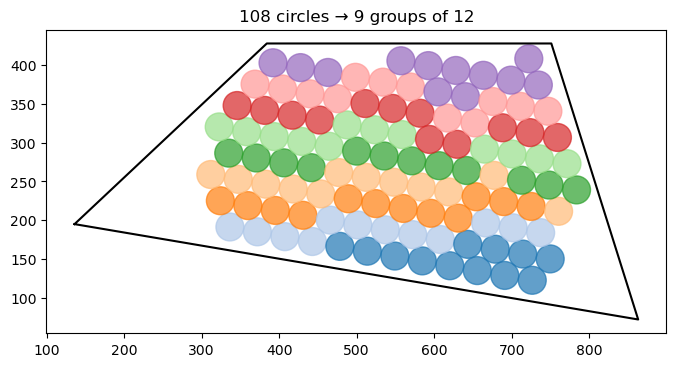

In [ ]:
# hex_grouping.py
"""
Algorithm to group hexagonally-arranged circles into contiguous, regular-shaped clusters using grid-based slicing.

Requirements:
- Input JSON with polygon boundary and list of circles (center, radius).
- Parameters: S = number of groups, P = circles per group.
- If total circles > S*P, discard outermost circles (farthest from centroid) to keep exactly S*P.
- Map each circle to hex-grid coordinates (row, col) based on center positions:
  - Vertical spacing = radius * sqrt(3).
  - Row index = round((y - y_min) / vertical_spacing).
  - For odd rows, apply x-offset = radius; else 0.
  - Column index = round((x - x_min - x_offset) / (2 * radius)).
- Sort circles by (row, col), flatten list and chunk into S groups of size P.
- Assign each circle a group ID and a distinct color.
- Save result to JSON with added 'group' and 'color' per circle and 'groups' list.
- Plot colored circles within the polygon using matplotlib.

This ensures each group is contiguous on the hex grid and approximates a rectangular block of P circles.
"""
import json
import math
import matplotlib.pyplot as plt


def load_data(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data['polygon'], data['circles']


def save_data(json_file, polygon, circles, groups=None):
    out = {'polygon': polygon, 'circles': circles}
    if groups is not None:
        out['groups'] = groups
    with open(json_file, 'w') as f:
        json.dump(out, f, indent=2)


def compute_centroid(circles):
    xs = [c['center'][0] for c in circles]
    ys = [c['center'][1] for c in circles]
    return (sum(xs)/len(xs), sum(ys)/len(ys))


def prune_circles(circles, target_count):
    if len(circles) <= target_count:
        return circles
    centroid = compute_centroid(circles)
    # distance squared from centroid
    dist_idx = [((c['center'][0]-centroid[0])**2 + (c['center'][1]-centroid[1])**2, idx)
                for idx, c in enumerate(circles)]
    # remove farthest
    dist_idx.sort(reverse=True)
    remove_idxs = set(idx for _, idx in dist_idx[:len(circles)-target_count])
    return [c for i, c in enumerate(circles) if i not in remove_idxs]


def map_to_grid(circles):
    # compute grid spacing
    R = circles[0]['radius']
    v_spacing = R * math.sqrt(3)
    xs = [c['center'][0] for c in circles]
    ys = [c['center'][1] for c in circles]
    x_min = min(xs)
    y_min = min(ys)
    mapped = []  # list of (row, col, idx)
    for idx, c in enumerate(circles):
        x, y = c['center']
        row = round((y - y_min) / v_spacing)
        x_offset = R if row % 2 else 0
        col = round((x - x_min - x_offset) / (2 * R))
        mapped.append((row, col, idx))
    return mapped


def assign_groups_grid(circles, S, P):
    n = len(circles)
    assert n == S*P, f"Require exactly S*P={S*P} circles, got {n}"
    mapped = map_to_grid(circles)
    # sort by row then col
    mapped.sort(key=lambda x: (x[0], x[1]))
    # flatten indices
    flat_idxs = [idx for _, _, idx in mapped]
    # chunk into S groups of P
    groups = [flat_idxs[i*P:(i+1)*P] for i in range(S)]
    return groups


def generate_colors(S):
    cmap = plt.get_cmap('tab20')
    colors = []
    for i in range(S):
        r, g, b, _ = cmap(i % 20)
        colors.append('#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255)))
    return colors


def main(input_file, output_file, S, P):
    polygon, circles = load_data(input_file)
    total = len(circles)
    target = S*P
    # prune excess
    circles = prune_circles(circles, target)
    # grid-based grouping
    groups = assign_groups_grid(circles, S, P)
    # assign colors
    colors = generate_colors(S)
    for gid, grp in enumerate(groups):
        for idx in grp:
            circles[idx]['group'] = gid
            circles[idx]['color'] = colors[gid]
    # save groups coords
    groups_coords = [[circles[idx]['center'] for idx in grp] for grp in groups]
    save_data(output_file, polygon, circles, groups_coords)
    # plot
    fig, ax = plt.subplots(figsize=(8,8))
    px, py = zip(*polygon)
    ax.plot(px, py, 'k-')
    for c in circles:
        circ = plt.Circle(tuple(c['center']), c['radius'], color=c['color'], alpha=0.7)
        ax.add_patch(circ)
    ax.set_aspect('equal')
    ax.set_title(f'{len(circles)} circles → {S} groups of {P}')
    plt.show()

if __name__ == '__main__':
    input_path = "polygon_with_circles.json"
    output_path = "polygon_with_circles_and_groups.json"
    S = 9
    P = 12

    main(input_path, output_path, S, P)


GPT-4o

/var/folders/20/448h2f1933x4jpn5p3l2lb7c0000gn/T/ipykernel_2646/1970993693.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(groups))


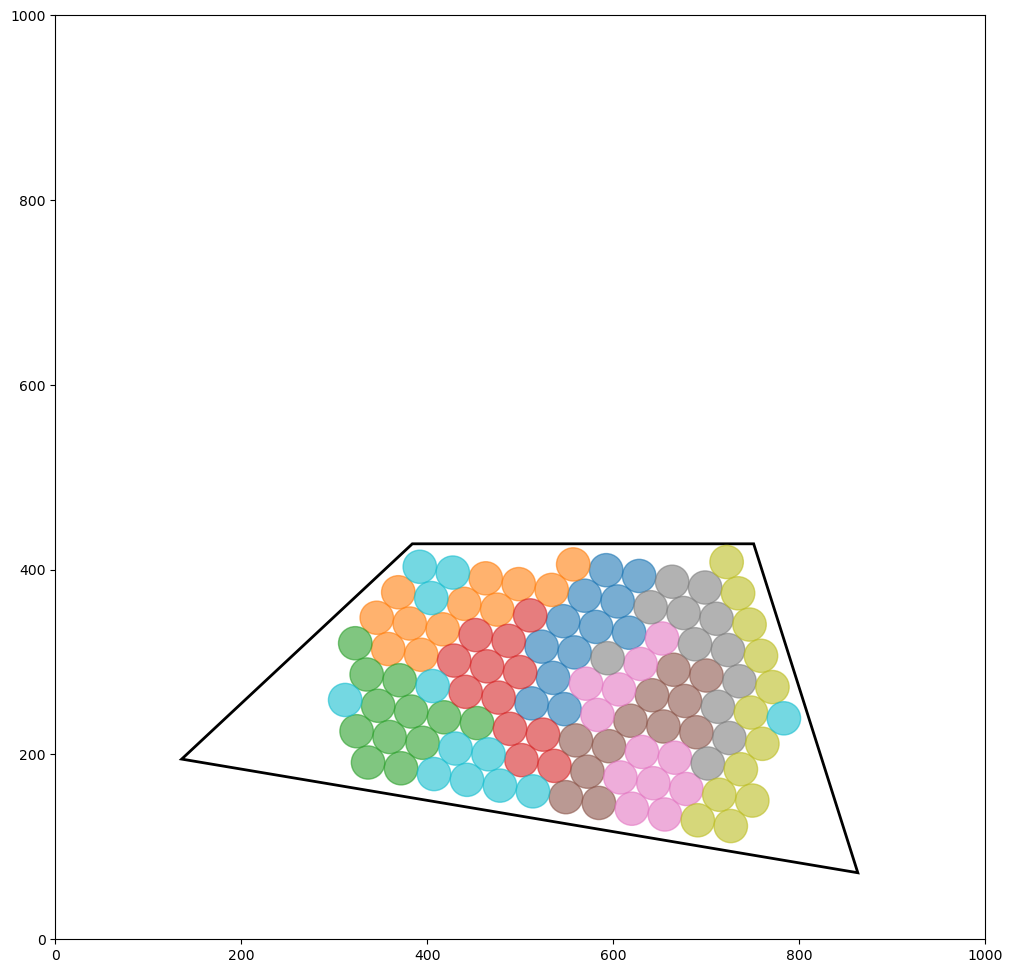

In [25]:
import json
import math
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def load_circles(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return data['polygon'], data['circles']


def save_circles(filename, polygon, circles, groups):
    data = {
        'polygon': polygon,
        'circles': circles,
        'gruppi': groups
    }
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)


def remove_excess_circles(circles, required_count):
    # Ordina i cerchi per distanza dal centroide (più vicini prima)
    centroid_x = sum(c['center'][0] for c in circles) / len(circles)
    centroid_y = sum(c['center'][1] for c in circles) / len(circles)
    circles.sort(key=lambda c: math.dist(c['center'], (centroid_x, centroid_y)))
    return circles[:required_count]


def group_circles(circles, S, P):
    groups = []
    remaining_circles = circles[:]
    for _ in range(S):
        group = []
        root_P = int(math.sqrt(P))
        while len(group) < P and remaining_circles:
            # Trova i cerchi più vicini al primo del gruppo per formare blocchi regolari
            if not group:
                group.append(remaining_circles.pop(0))
            else:
                last_circle = group[-1]
                remaining_circles.sort(key=lambda c: math.dist(c['center'], last_circle['center']))
                group.append(remaining_circles.pop(0))
        groups.append([c['center'] for c in group])
    return groups


def visualize_groups(polygon, groups):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xlim(0, 1000)
    ax.set_ylim(0, 1000)

    # Disegna il poligono
    polygon_points = [tuple(p) for p in polygon]
    polygon_shape = patches.Polygon(polygon_points, closed=True, fill=False, edgecolor='black', linewidth=2)
    ax.add_patch(polygon_shape)

    # Disegna i gruppi
    colors = plt.cm.get_cmap('tab10', len(groups))
    for i, group in enumerate(groups):
        color = colors(i)
        for center in group:
            circle = patches.Circle(center, radius=18, edgecolor=color, facecolor=color, alpha=0.6)
            ax.add_patch(circle)

    plt.show()


def main():
    S = 9  # Numero di gruppi
    P = 12  # Numero di cerchi per gruppo
    input_file = 'polygon_with_circles.json'
    output_file = 'polygon_with_circles_and_groups.json'

    # Carica dati dal file JSON
    polygon, circles = load_circles(input_file)

    # Rimuovi cerchi in eccesso
    total_required = S * P
    if len(circles) > total_required:
        circles = remove_excess_circles(circles, total_required)

    # Crea i gruppi
    groups = group_circles(circles, S, P)

    # Salva il risultato
    save_circles(output_file, polygon, circles, groups)

    # Visualizza il risultato
    visualize_groups(polygon, groups)


if __name__ == '__main__':
    main()
